In [1]:
!pip install tensorflow

You should consider upgrading via the 'c:\users\park\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [105]:
!pip install scikit-learn

You should consider upgrading via the 'c:\users\park\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [107]:
!pip install seaborn

You should consider upgrading via the 'c:\users\park\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# VGG-16

Train and validate the VGG-16 model on PKLot dataset. The model is trained using transfer learning technique in tensorflow.keras library

In [1]:
from tensorflow.keras.layers import Flatten, Dense, Dropout # 평탄화, 밀집층, 드롭아웃
from tensorflow.keras.models import Model, Sequential # 모델, 모델 설정
from tensorflow.keras.optimizers import SGD # 옵티마이저
from tensorflow.keras.optimizers import Adam # 옵티마이저

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img # 이미지 증식 클래스 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
HEIGHT = 224
WIDTH = 224

# Instantiate the base model to extract features
base_model = VGG16(weights='imagenet', # 이미지넷에서 학습된 weights를 가져옴 -> pretrained = true
                      include_top=False, # fc 층을 가져오지 않음
                      input_shape=(HEIGHT, WIDTH, 3)) # 입력 이미지 크기

In [7]:
TRAIN_DIR = "D:/1900_python/6_project/Test/train"
BATCH_SIZE = 32

train_datagen =  ImageDataGenerator( # 훈련 이미지 증식 객체
      preprocessing_function=preprocess_input,
      rescale = 1./255,
      rotation_range=90, # 이미지를 최대 90도까지 돌려서 이미지 증식
      horizontal_flip=True, # 좌우반전 허용
      vertical_flip=True, # 상하반전 허용
    )

# flow_from_directory : 이미지를 불러올 때 폴더명에 맞춰서 자동으로 라벨링 해줌
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, # 훈련 데이터 위치
                                                    target_size=(HEIGHT, WIDTH), # 훈련 이미지 사이즈
                                                    batch_size=BATCH_SIZE, # 미니 배치 사이즈
                                                   class_mode='binary',
                                                   shuffle = True) # "binary"는 1D 형태의 이진 라벨입니다, "sparse"는 1D 형태의 정수 라벨입니다,

Found 1800 images belonging to 2 classes.


In [8]:
VALID_DIR = "D:/1900_python/6_project/Test/test"
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_generator = valid_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        shuffle = True,
        class_mode='binary')

Found 450 images belonging to 2 classes.


In [9]:
# print(base_model.summary())

In [10]:
# Freeze the base model not to train
for layer in base_model.layers:
        layer.trainable = False

In [11]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [12]:
# Define the top/final layers to do classifiction
x = base_model.output
x = Flatten()(x) # 평탄화
x = Dense(256, activation='relu')(x) # 활성화
x = Dropout(0.5)(x) # 드롭아웃
pred = Dense(1, activation='sigmoid')(x) # sigmoid 활성화 함수 (클래스가 3개 이상이면 softmax로 해야됨), 
                                         # 여기에서는 주차공간이 비어 있거나 비어 있지 않는 두 가지 경우밖에 없기 때문에 sigmoid 함수를 사용함

tf_model = Model(inputs=base_model.input, outputs=pred)

In [13]:
base_model.input # 훈련 데이터 이미지 사이즈 및 채널 확인

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [14]:
pred

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [15]:
len(train_generator)

57

In [16]:
print(tf_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from tensorflow import keras

# Choose the optimizers that works well with the dataset
tf_model.compile(loss='mean_squared_error', # 'binary_crossentropy' 다중분류일 경우 categorical_crossentropy나 sparse_categorical_crossentropy로 바꿔야 함
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy']) # 에포크가 끝날 때마다 정확도를 알려줌

# 콜백 함수들
# checkpoint : 가장 성능이 좋았던 모델을 저장함
checkpoint = keras.callbacks.ModelCheckpoint('best-model.h5',
                                               save_best_only = True)

# early_stopping : 정확도가 4번의 에포크 동안 좋아지지 않으면 남은 에포크를 다 돌지 않고 학습을 끝냄
early_stopping = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [18]:
# 모델 학습 환경
nb_train_samples = 1800
nb_validation_samples = 450
batch_size =  32
epochs = 10

In [19]:
# Fine-tune the model
tf_hist = tf_model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size, # 한 번의 에포크에 몇 개의 배치가 들어가는지
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks = [checkpoint, early_stopping])

C:\Users\Park\AppData\Local\Temp\ipykernel_17080\1233849067.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  tf_hist = tf_model.fit_generator(


Epoch 1/10
56/56 [==============================] - 633s 11s/step - loss: 0.1331 - accuracy: 0.8117 - val_loss: 0.0867 - val_accuracy: 0.8929
Epoch 2/10
56/56 [==============================] - 553s 10s/step - loss: 0.0661 - accuracy: 0.9186 - val_loss: 0.0778 - val_accuracy: 0.9107
Epoch 3/10
56/56 [==============================] - 540s 10s/step - loss: 0.0469 - accuracy: 0.9474 - val_loss: 0.0579 - val_accuracy: 0.9330
Epoch 4/10
56/56 [==============================] - 549s 10s/step - loss: 0.0345 - accuracy: 0.9638 - val_loss: 0.0585 - val_accuracy: 0.9353
Epoch 5/10
56/56 [==============================] - 546s 10s/step - loss: 0.0298 - accuracy: 0.9683 - val_loss: 0.0505 - val_accuracy: 0.9464
Epoch 6/10
56/56 [==============================] - 540s 10s/step - loss: 0.0298 - accuracy: 0.9678 - val_loss: 0.0491 - val_accuracy: 0.9397
Epoch 7/10
56/56 [==============================] - 543s 10s/step - loss: 0.0254 - accuracy: 0.9706 - val_loss: 0.0465 - val_accuracy: 0.9442
Epoch 

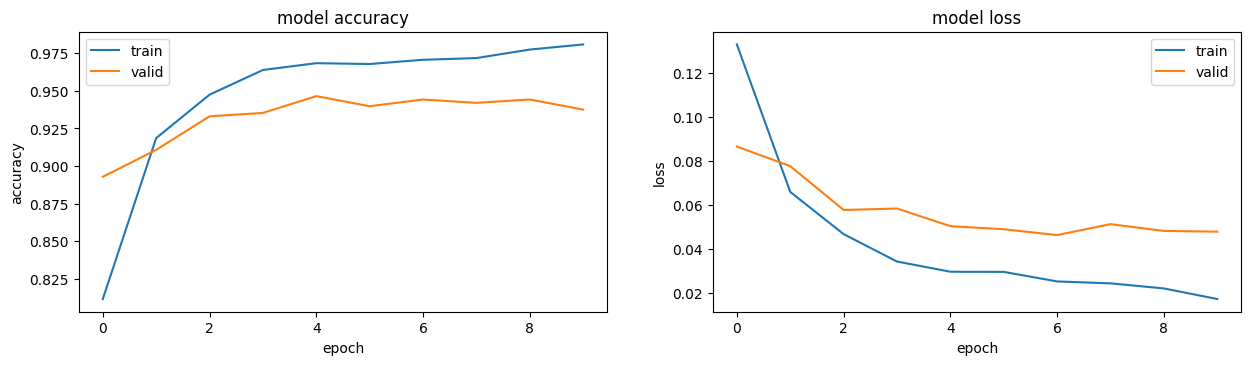

In [22]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(tf_hist.history['accuracy'])  
plt.plot(tf_hist.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(tf_hist.history['loss'])  
plt.plot(tf_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

## Model prediction on validation dataset

In [23]:
from glob import glob
import numpy as np
from tensorflow.keras.utils import load_img
import cv2

In [26]:
occupied_dir = "D:/1900_python/6_project/Test/test/occupied/*.jpg"
empty_dir = "D:/1900_python/6_project/Test/test/empty/*.jpg"

# 검증데이터의 occupied_dir과 empty_dir의 모든 jpg 파일을 저장
valid_images = glob(occupied_dir) + glob(empty_dir)

In [27]:
valid_images

['D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__026.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__027.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__028.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__029.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__030.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__031.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__032.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__033.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__034.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__035.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__036.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_43__037.jpg',
 'D:/1900_python/6_project/Test/test/occupied\\2012-11-20_19_39_

In [56]:
li1 =valid_images[1].split('\\')[-2]

In [58]:
li1.split('/')[-1]

'empty'

In [46]:
type(valid_images)

list

In [29]:
valid_images = list(valid_images)
np.random.shuffle(valid_images) # 검증 데이터를 섞어줌

In [30]:
import os
import pandas as pd

data_df = pd.read_csv(os.path.join('D:/1900_python/6_project/Test', 'PK_data_na_MeanRemove.csv'))

In [41]:
data_df.head()

,filename,center_x,center_y,width,height,angle,occupied,x_max,x_min,y_max,y_min
0,2012-11-07_18_34_52_1,300,207,55,32,-74,NaN,324,278,230,185
1,2012-11-07_18_34_52_2,332,209,56,33,-77,NaN,355,310,233,185
2,2012-11-07_18_34_52_3,366,208,52,32,-77,NaN,388,345,233,185
3,2012-11-07_18_34_52_4,398,207,54,36,-79,NaN,421,375,232,184
4,2012-11-07_18_34_52_5,430,210,50,31,-75,NaN,452,409,232,187


In [69]:
ground_truth = []
prediction = []
for img in valid_images:
    # 이미지 아이디 추출
    id = id.split("\\")[-1]
    id = img.split(".")[0] 
    # 이미지 결과 추출
    result = img.split('\\')[-2]
    result = result.split('/')[-1]
#     id = id.replace('__', '_')
#     id = id.replace('#', '_')
   
    # csv에 저장된 이미지 특성 가져오기
    meta_data = data_df[data_df['filename'] == id]
    # 실제로 csv에 저장된 결과 (0, 1)
    ground_truth.append(1 if result == 'occupied' else 0)
    
    # img = 경로 + img
    image = cv2.imread(img)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image_x = np.expand_dims(image, axis=0)
    image_x = preprocess_input(image_x)
    pred = tf_model.predict(image_x) # 전처리된 이미지가 결과 예측
    pred = np.squeeze(pred)
    if pred > 0.93: # 예측 확률이 0.93 이상이면 주차 공간이 비어 있지 않다고 결정
        prediction.append(1)
    else:
        prediction.append(0)
    

1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 275ms/step


In [63]:
ground_truth

['!',
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1

In [70]:
len(ground_truth)

450

In [64]:
prediction

['!',
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1

In [71]:
len(prediction)

450

In [100]:
# 결과 예측과 실제 결과 비교
# 결과 예측한 것과 실제 결과의 빈공간의 개수를 구함
# 원본 사진에 100개의 주차 공간이 있기 때문에 100개를 기준으로 함
actual = 0
predicted = 0

temp_p = 0
temp_a = 0
result = {}

for i, g in enumerate(ground_truth) :
    if g == 0 :
        temp_a += 1
    if prediction[i] == 0 :
        temp_p += 1
    if i % 100 == 0 :
        result[f'{int(i/99)}-actual'] = temp_a
        result[f'{int(i/99)}-predicted'] = temp_p
        
        actual += temp_a
        predicted += temp_p
        
        temp_a = 0
        temp_p = 0

In [101]:
result_df = pd.DataFrame(result, index = [0])

In [102]:
result_df

,0-actual,0-predicted,1-actual,1-predicted,2-actual,2-predicted,3-actual,3-predicted,4-actual,4-predicted
0,0,0,56,46,44,35,49,40,53,49


In [103]:
predicted/actual # 정확도

0.8415841584158416

In [108]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [109]:
# Show the classification metrics
print(classification_report(ground_truth, prediction, target_names=['Empty', 'Occupied']))

              precision    recall  f1-score   support

       Empty       0.96      0.81      0.88       225
    Occupied       0.84      0.96      0.90       225

    accuracy                           0.89       450
   macro avg       0.90      0.89      0.89       450
weighted avg       0.90      0.89      0.89       450

